<a href="https://colab.research.google.com/github/hm115/PHI-XPS-Python/blob/main/Updated_tgmeow_Read_and_Plot_Spectrum_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You can use the built in "Files" explorer on the left bar to view your Google Drive.

In [ ]:
from google.colab import drive
import numpy as np
import struct
import array
import matplotlib.pyplot as plt
import sys

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class XSpectrum:

    def __init__(self):
        self._regions = []
        self._XPS_REGION_START_STR = b'DP'
        self._XPS_HEADER_SIZE = 42
   
    def load_xps(self, path):
        """
        Read and parse XPS file according to the reverse engineering of
        Robert Forest's Python3convert-multipak-to-XPSPEAK-columbia.py
        """
        file_str = ""
        # We read in the entire file because iterating through is tedious.
        with open(path, 'rb') as f:
            print('Reading XPS from ' + path)
            file_str = f.read();
            f.close()

        version_str = file_str[0:11].decode('utf-8')
        print(f'File version is: {version_str}')

        idx = file_str.find(self._XPS_REGION_START_STR) + len(self._XPS_REGION_START_STR)
        while idx != -1:
            print(f'IDX: {idx}')
            (region, size) = self.__xps_read_region(file_str, idx)
            self._regions.append(region)
            idx = file_str.find(self._XPS_REGION_START_STR, idx + size) + len(self._XPS_REGION_START_STR)

        print('Done!')
    
  
    def load_spe(self, path):
        """
        Read and parse SPE file according to the reverse engineering of
        Robert Forest's Python3convert-multipak-to-XPSPEAK-columbia.py
        """
        with open(path, 'rb') as f:
            print('Reading SPE from ' + path)
            num_regions = self.__spe_get_number_of_regions(f)
            BE_parameters = self.__spe_get_BE_parameters(f, num_regions)
            self.__spe_convert_multipak_file(f, BE_parameters, num_regions)
        print('Done!')

    # XPS helper functions
    def __xps_read_region(self, file_str, idx):
        """
        """
        curr_reg = dict()

        """ Header contains: (total 42 bytes)
        0: region_size (2 bytes)
        1: unknown: uint 655353 (4)
        2: 20 characters for the region_name, with whitespace padding (20)
        3: region_size again ?? (2)
        4: unknown: int of 1 (2)
        5: region_size + 1 (2)
        and 10 zeros to end the header (10)
        """
        region_header = struct.unpack_from('<HI20sHHH10x', file_str, idx)
        print(region_header)
        idx += self._XPS_HEADER_SIZE

        curr_reg['region_size'] = region_header[0]
        curr_reg['region_name'] = region_header[2].strip()
        
        # Read region be
        curr_reg['be_data'] = np.array(struct.unpack_from(f'<{region_header[0]}f', file_str, idx))
        idx += region_header[0] * 4

        # Strange whitespace of 1, region_size+1, and 10 zeros
        unknown_whitespace = struct.unpack_from('<HH10x', file_str, idx)
        idx += 14

        # Read region intensity
        curr_reg['intensity'] = np.array(struct.unpack_from(f'<{region_header[0]}f', file_str, idx))
        idx += region_header[0] * 4

        """ Footer contains:
        0: max_BE
        1: min_BE
        2: max_intensity
        3: min_intensity
        and LOTS of whitespace for some reason...
        """
        region_footer = struct.unpack_from('<4f', file_str, idx)
        idx += 76

        curr_reg['max_be'] = region_footer[0]
        curr_reg['min_be'] = region_footer[1]
        curr_reg['max_intensity'] = region_footer[2]
        curr_reg['min_intensity'] = region_footer[3]

        # I think it's nothing but idk why
        region_post_footers = []
        for i in range(6):
            region_post_footers.append(struct.unpack_from(f'<HH10x{region_header[0]}f', file_str, idx + i*18+region_header[0]*4))

        curr_reg['post_footers'] = region_post_footers
        
        region_size = self._XPS_HEADER_SIZE + region_header[0] * 4 * 2 + 14 + 16 + (6 *(2+2+region_header[0]*4+10)) + 18

        return (curr_reg, region_size)


    # SPE helper functions

    def __spe_get_number_of_regions(self, file):
        """
        Returns the total number of elements ("regions") from multi-scan
        """
        file_string = file.read()
        i = file_string.rfind(b'NoSpectralReg: ') + len('NoSpectralReg: ')
        file.seek(i)
        return int(file.readline())

    def __spe_get_BE_parameters(self, file, num_regions):
        """Returns a 2D list of binding energy parameters as strings
        First dimension is the region number
        Second dimension is a list of individual parameters for that region
        Indices: 3-region name, 5-region size, 6-step size, 7-high BE, 8-low BE
        """
        BE_parameters = []
        for line_number in range(num_regions):
            BE_parameters.append(file.readline())
            BE_parameters[line_number] = BE_parameters[line_number].split(b' ')
        return BE_parameters

    def __spe_convert_multipak_file(self, file, BE_parameters, num_regions):
        # Set up regions.
        self._regions = [dict() for _ in range(num_regions)]

        # Go to start of data in multipak file.
        data_size = 0
        for i in range(num_regions):
            data_size += int(BE_parameters[i][5])
        file.seek(-8 * data_size, 2) 

        # Process data in each region.
        for i in range(num_regions):
            # Reference to regions dict.
            curr_reg = self._regions[i]

            region_params = BE_parameters[i]
            curr_reg['max_be'] = float(region_params[7])
            curr_reg['min_be'] = float(region_params[8])
            curr_reg['region_size'] = int(region_params[5])
            intensity_data_double = array.array('d')
            intensity_data_double.fromfile(file, curr_reg['region_size'])
                        
            # Region metadata.  Not sure if useful.
            curr_reg['region_name'] = region_params[3]

            # I guess XPS format doesn't support double?
            curr_reg['be_data'] = np.linspace(curr_reg['max_be'], curr_reg['min_be'], curr_reg['region_size'])

            curr_reg['intensity'] = np.array(intensity_data_double)

            curr_reg['min_intensity'] = min(curr_reg['intensity'])
            curr_reg['max_intensity'] = max(curr_reg['intensity'])

In [ ]:
data1 = XSpectrum()
# data1.load_xps('/content/drive/My Drive/xps_experiments/2001170002_Fitted_3.xps')
# data1.load_spe('/content/drive/My Drive/xps_experiments/2001170002.spe')
data1.load_spe('/content/drive/My Drive/Forschung/Data/XPS/XPS Data/Mo2C/200911_Mo2C_syn1_fine0002.SPE')
# print(data1._regions[0])

# TODO the problem with XPS is that settings and curves are included in the file format. The exact encoding is not clear. It is also not clear where the number of regions is indicated.
#data2 = XSpectrum()
#data2.load_xps('/content/drive/My Drive/xps_experiments/2001170002_Fitted_3.xps')
# data2.load_xps('/content/drive/My Drive/xps_experiments/C1s.xps')

Reading SPE from /content/drive/My Drive/Forschung/Data/XPS/XPS Data/Mo2C/200911_Mo2C_syn1_fine0002.SPE
Done!


In [ ]:
len(data1._regions)

4

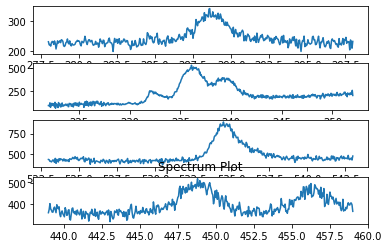

In [ ]:
fig, ax = plt.subplots(4)
for i in range(len(data1._regions)):
    ax[i].plot(data1._regions[i]['be_data'], data1._regions[i]['intensity'])
plt.title("Spectrum Plot")
plt.show()